In [1]:
%load_ext autoreload
%autoreload 2

import sys, os

import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt
import qutip.visualization as qplt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [9.7, 6]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1.054e-34
h = hbar*2*np.pi
qe = 1.602e-19
red_flux_quant = hbar/2/qe 

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

Plotting functions

In [3]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def show_mat_2d(mat, ax, title, labels, cmax=1, show=True):
    """
    Plot an arbitrary 2D matrix with labels
    """
    plt.sca(ax)
    plt.title(title, fontsize=18)
    plt.imshow(np.real(mat), cmap='RdBu')
    # hinton(np.real(mat), xlabels=labels, ylabels=labels)
    plt.xticks(np.arange(len(mat)), labels, fontsize=18)
    plt.yticks(np.arange(len(mat)), labels, fontsize=18)
    # Loop over data dimensions and create text annotations.
    for ii in range(len(mat)):
        for jj in range(len(mat)):
            plt.text(ii, jj, round(mat[jj, ii], 3), ha="center", va="center", color="w", size=16)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(cax=cax, ticks=[-cmax, 0, cmax])
    cbar.ax.tick_params(labelsize=14)
    plt.clim(vmin=-cmax, vmax=cmax)
    plt.tight_layout()
    if show: plt.show()

def show_plot_rho_2d(rho_sim, rho_id=None, title='', cmax=None, savetitle=None):
    """
    Plot real and imag parts of rho, optionally also with a comparison ideal rho
    """
    if savetitle is not None: plt.style.use('dark_background')

    labels = ["00", "01", "10", "11"]
    if rho_id is None:
        fig = plt.figure(figsize=(12, 4))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        fig = plt.figure(figsize=(10, 8))
        ax1 = fig.add_subplot(221)
        ax2 = fig.add_subplot(222)
        ax3 = fig.add_subplot(223)
        ax4 = fig.add_subplot(224)
    plt.suptitle(title, fontsize=18)
    if cmax is None: cmax = np.max(np.abs(np.array([np.real(rho_sim), np.imag(rho_sim), np.real(rho_id), np.imag(rho_id)])))
    show_mat_2d(np.real(rho_sim), ax=ax1, title="Re[$\\rho_{Sim}$]", labels=labels, cmax=cmax, show=False)
    show_mat_2d(np.imag(rho_sim), ax=ax2, title="Im[$\\rho_{Sim}$]", labels=labels, cmax=cmax, show=False)
    if rho_id is not None:
        show_mat_2d(np.real(rho_id), ax=ax3, title="Re[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
        show_mat_2d(np.imag(rho_id), ax=ax4, title="Im[$\\rho_{Ideal}$]", labels=labels, cmax=cmax, show=False)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent = True)
    
    plt.show()


def show_plot_rho_3d(rho_sim, rho_id=None, title='', zmin=None, zmax=None, width=0.75, elev=30, azim=-20, savetitle=None):
    if savetitle is not None: plt.style.use('dark_background')
    fig = plt.figure(figsize=(15, 7))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    
    labels = ["00", "01", "10", "11"]
    _xx, _yy = np.meshgrid(np.arange(4), np.arange(4))
    x, y = _xx.ravel(), _yy.ravel()
    if zmax is None: zmax = np.max(np.array([np.real(rho_sim), np.imag(rho_sim), np.real(rho_id), np.imag(rho_id)]))
    if zmin is None: zmin = np.min((0, np.min(np.array([np.real(rho_sim), np.imag(rho_sim), np.real(rho_id), np.imag(rho_id)]))))

    ax1.view_init(elev=elev, azim=azim)
    ax1.set_xticks(np.arange(4), minor=False)
    ax1.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax1.set_yticks(np.arange(1, 5, 1), minor=False)
    ax1.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax1.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.real(rho_id).flatten(), edgecolor='k', alpha=0)
    ax1.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.real(rho_sim).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax1.set_zlim(zmin, zmax)
    ax1.set_title("Re[$\\rho$]", fontsize=20)

    ax2.view_init(elev=elev, azim=azim)
    ax2.set_xticks(np.arange(4), minor=False)
    ax2.set_xticklabels(labels, fontdict=None, minor=False, fontsize=16)
    ax2.set_yticks(np.arange(1, 5, 1), minor=False)
    ax2.set_yticklabels(labels, fontdict=None, minor=False, fontsize=16)
    for t in ax2.zaxis.get_major_ticks(): t.label.set_fontsize(16)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=width, dy=width, dz=np.imag(rho_id).flatten(), edgecolor='k', alpha=0)
    ax2.bar3d(x, y, z=np.zeros((16)), dx=0.95*width, dy=width, dz=np.imag(rho_sim).flatten(), color='cornflowerblue', edgecolor='mediumblue', alpha=1.0)
    ax2.set_zlim(zmin, zmax)
    ax2.set_title("Im[$\\rho$]", fontsize=20)

    plt.suptitle(title, fontsize=22)
    plt.tight_layout()

    if savetitle is not None:
        plt.savefig(savetitle, format='png', bbox_inches='tight', transparent=True)
    plt.show()

# Get couplings and bare frequencies by optimization

In [4]:
sys.path.append(os.getcwd()+'/../../qutip_sims')
from scipy.optimize import minimize
from slab import AttrDict

 c:\ProgramData\Anaconda3\lib\site-packages\IPython\qt.py: 12

Could not load InstrumentManagerWindow
Could not import QickSoc: No module named 'pynq'
Could not import QickInstrument, try install qick package
Could not load labbrick
Could not load Autonics TM4 Driver
Could not load Oxford Trition driver


In [5]:
# Provide measured qubit freqs (GHz), alphas (GHz), ZZ matrix (GHz)
# For use in optimization
def ZZ_g_fq_diff(fqs_gs, *args):
    qubit_freqs, alphas, ZZ_matrix = args # measured values
    fqs = fqs_gs[:4] 
    gs = fqs_gs[4:]
    # print(args)
    qram = QSwitch(
        EJs=None,
        ECs=None,
        gs=gs,
        qubit_freqs=fqs,
        alphas=alphas,
        cutoffs=[4, 5, 4, 4],
        isCavity=[False]*4,
    )
    # print(qram.get_ZZ_matrix())
    # return np.sum(np.abs(ZZ_matrix - qram.get_ZZ_matrix()))
    error_ZZ = np.sum(np.abs(1e3*(ZZ_matrix - qram.get_ZZ_matrix()))**2)
    error_fq = 0
    gstate = 'gggg'
    for i in range(4):
        estate = gstate[:i] + 'e' + gstate[i+1:]
        error_fq += np.sum(np.abs(1e3*(qram.get_base_wd(gstate, estate)/2/np.pi - qubit_freqs[i])**2))
    return error_ZZ + error_fq

In [8]:
# config_dir = 'C:\\Users\\slab\\Desktop\\Connie\\experiments\\qramLL_4QR2'
config_dir = 'S:\\Connie\\experiments\\qramLL_4QR2'
# config_file = 'config_zcu216.yml'
# config_file = 'config_q3diamond.yml'
# config_file = 'config_q3diamond_full688_reset.yml'
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = config_dir + '\\' + config_file
print('Config will be', config_path)

Config will be S:\Connie\experiments\qramLL_4QR2\config_q3diamond_full688and638_reset.yml


In [9]:
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

qubit_freqs_MHz = np.array(yaml_cfg.device.qubit.f_ge) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq)
alphas_MHz = np.array(yaml_cfg.device.qubit.f_ef) + np.array(yaml_cfg.hw.soc.dacs.qubit.mixer_freq) - qubit_freqs_MHz
ZZshifts_MHz = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) # MHz

print('qubit freqs', qubit_freqs_MHz)
print('alphas', alphas_MHz)

qubit freqs [4130.20013498 3456.36634828 4785.14052899 4398.30474102]
alphas [-225.46539508 -100.36622051 -189.64499335 -172.63621201]


In [ ]:
delta_fq = 20e-3 # GHz away from measured
x0 = np.array([*qubit_freqs_MHz, 100, 100, 100, 10, 10, 10])
bounds_fq = [(1e-3*fq_MHz - delta_fq, 1e-3*fq_MHz + delta_fq) for fq_MHz in qubit_freqs_MHz]
bounds = [*bounds_fq, (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1), (1e-3, 2e-1)] # GHz

result = minimize(ZZ_g_fq_diff, x0=1e-3*x0, args=(1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts_MHz), bounds=bounds , method='L-BFGS-B')

In [ ]:
print(f'Success: {result.success}')
fqs_gs_opt = result.x
fqs_opt = fqs_gs_opt[:4] 
gs_opt = fqs_gs_opt[4:]

Success: True


In [ ]:
qram = QSwitch(
    EJs=None,
    ECs=None,
    gs=gs_opt,
    qubit_freqs=fqs_opt,
    alphas=1e-3*alphas_MHz,
    cutoffs=[4, 5, 4, 4],
    isCavity=[False]*4,
)
print('Measured (coupled) qubits freqs [MHz]')
print(qubit_freqs_MHz)
print('Optimized (uncoupled) qubit freqs [MHz]')
print(1e3*fqs_opt)
print(f'Optimized g01, g12, g13, g02, g03, g23 [MHz]: {1e3*gs_opt}')
print()
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
print('Measured ZZ matrix [MHz]')
print(ZZshifts_MHz)
print('Optimized ZZ matrix [MHz]')
print(1e3*qram.get_ZZ_matrix())
print()
print(f'Optimization error: {ZZ_g_fq_diff(fqs_gs_opt, 1e-3*qubit_freqs_MHz, 1e-3*alphas_MHz, 1e-3*ZZshifts_MHz)}')

Measured (coupled) qubits freqs [MHz]
[4140.53027073 3463.72489158 4800.07924655 4415.18623279]
Optimized (uncoupled) qubit freqs [MHz]
[4136.58255346 3471.6494364  4797.76939898 4413.51922713]
Optimized g01, g12, g13, g02, g03, g23 [MHz]: [53.2742199  52.18110346 40.69199643  6.33890349  2.85862392  6.00968168]

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
Measured ZZ matrix [MHz]
[[ 0.         -5.11459456 -0.18282364 -0.49816423]
 [-5.10282396  0.         -0.94440877 -1.06069598]
 [-0.18631446 -0.95319033  0.         -0.48414733]
 [-0.50653941 -1.09093474 -0.40800301  0.        ]]
Optimized ZZ matrix [MHz]
[[ 0.         -5.10870823 -0.18456907 -0.50235016]
 [-5.10870823  0.         -0.94880055 -1.07581587]
 [-0.18456907 -0.94880055  0.         -0.44607519]
 [-0.50235016 -1.07581587 -0.44607519  0.        ]]

Optimization error: 0.0035051665967743926


In [ ]:
# MAKE SURE DRESSED STATES ARE MAPPED CORRECTLY, AT LEAST FOR <= n EXCITATIONS
# qram.check_state_mapping(n=3)

# Set qubit parameters

In [128]:
# # q_in, q_switch, q_out1, q_out2

# # EJs = [13.41, 12.52, 8.94, 12.52]
# # EJs = [12.109, 11.195, 7.997, 11.195]
# # EJs = [17.523, 16.450, 11.622, 16.450]

# # ECs = [0.237, 0.133, 0.270, 0.215]

# # gs = [0.0827, 0.0787, 0.0652] # g01, g12, g13
# # gs = [1e-3*73.44448637160531, 1e-3*70.62005211780702, 1e-3*58.4998799537415]
# # gs = [1e-3*88.68898701296644, 1e-3*85.3693409331001, 1e-3*70.91300299056793]
# # gs = [0,0,0]
# # gs = [1e-3*66.56542672271766, 1e-3*65.06457214018066, 1e-3*51.68752851908644]
# # gs = [0.0613, 0.0600, 0.0475]

# qubit_freqs = None
# alphas = None

# EJs = None
# ECs = None
# # qubit_freqs = np.array([4140.530270731964, 3463.742568636059, 4800.079246546452, 4415.18623279066])*1e-3
# qubit_freqs = np.array([4140.53027073, 3463.72489158, 4800.07924655, 4415.18623279])*1e-3
# # alphas = [-0.182, -0.108, -0.220, -0.168]
# ef_freqs = np.array([3914.7570214638718, 3363.398427976613, 4610.7977211230145, 4243.1626645869358])*1e-3
# alphas = ef_freqs - qubit_freqs
# print(alphas)
# gs = np.array([54.38663964, 52.60236201, 41.1249601,   6.26475719,  2.73059709,  6.00700312])*1e-3 # g01, g12, g13, g02, g03, g23
# # gs = gs[:3]

# # qubit_freqs = np.array([4146.29086881774893, 3464.7403852710677, 4806.4284729347243, 4426.85588770023173])*1e-3
# # # alphas = [-0.182, -0.108, -0.220, -0.168]
# # ef_freqs = np.array([4000-78.90376315971923, 3364.253, 4611.098326885819, 4254.36098271568733])*1e-3
# # alphas = ef_freqs - qubit_freqs
# # print(alphas)
# # gs = [0.054, 0.043, 0.040] # g01, g12, g13

from slab import  AttrDict
config_file = 'config_q3diamond_full688and638_reset.yml'
config_path = os.getcwd() + '\\..\\experiments\\qramLL_4QR2\\' + config_file
import yaml
with open(config_path, 'r') as cfg_file:
    yaml_cfg = yaml.safe_load(cfg_file)
yaml_cfg = AttrDict(yaml_cfg)

qubit_freqs = np.array(yaml_cfg.device.qubit.f_ge) * 1e-3
qubit_freqs[1]+=5e-3
ef_freqs = np.array(yaml_cfg.device.qubit.f_ef) * 1e-3
gs = np.array(yaml_cfg.device.qubit.gs) * 1e-3

ZZs_4q = np.reshape(np.array(yaml_cfg.device.qubit.ZZs), (4,4)) * 1e-3
EJs = None
ECs = None
alphas = ef_freqs - qubit_freqs

print(qubit_freqs)
print(alphas)


[4.13020013 3.46136635 4.78514053 4.39830474]
[-0.2254654  -0.10536622 -0.18964499 -0.17263621]


# Analytical swap

In [129]:
cutoffs = [4, 5, 4, 4]
# cutoffs = [2, 3, 2, 2]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    ZZs=ZZs_4q,
    qubit_freqs=qubit_freqs,
    alphas=alphas,
    cutoffs=cutoffs,
    isCavity=isCavity,
    useZZs=False,
)

# qram = QSwitch(
#     EJs=EJs,
#     ECs=ECs,
#     qubit_freqs=qubit_freqs,
#     alphas=alphas,
#     cutoffs=cutoffs,
#     isCavity=isCavity,
#     gs=None,
#     useZZs=True,
#     ZZs=ZZshifts_MHz*1e-3,
# )


qubit_freqs = qram.qubit_freqs
alphas = qram.alphas
print('qubit freqs (GHz)', *qubit_freqs)
print('alphas (GHz)', *alphas)
# print('aprox sideband freqs (GHz)', 2*qubit_freqs[1] + alphas[1] - qubit_freqs)
# print([qram.get_base_wd('ggeg', 'gfgg')/2/np.pi])


# print('capacitances (fF)', *(qe**2/(2*h*np.array(ECs)*1e9)*1e15))
# print('lumped L (nH)', *(red_flux_quant**2/h/np.array(EJs)))

qubit freqs (GHz) 4.1302001349834745 3.461366348279435 4.785140528992779 4.398304741018806
alphas (GHz) -0.22546539508285335 -0.10536622050866118 -0.18964499334802465 -0.1726362120064433


In [188]:
print('ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]')
print('Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)')
print(1e3*qram.get_ZZ_matrix())

ZZ matrix = (QA freq when QB is in e) - (QA freq when QB is in g) [MHz]
Down: spectroscopy qubit (QA), Right: pi pulse qubit (QB)
[[ 0.         -5.23752274 -0.22882081 -0.57972463]
 [-5.23752274  0.         -1.05774695 -1.2709038 ]
 [-0.22882081 -1.05774695  0.         -0.49630524]
 [-0.57972463 -1.2709038  -0.49630524  0.        ]]


## Create pulse sequence

### Set pulses phases and amps

In [332]:
phase_I = -np.pi/2 # |0+1>
# phase_I = -np.pi # |0+i1>

phase_S = -np.pi/2 #  doesn't affect the protocol implementation, just definining the initialization phase (?)

phase_IS = 0
phase_SL = 0
phase_SR = 0

amp_swap_01 = 0.08
amp_swap_12 = 0.08
amp_swap_13 = 0.08
amp_pi = 0.01 # pi pulse in the protocol
amp_pi_2 = 0.01 # init pi pulse amp
amp_pi_2_2 = 0.01

### Defining the ideal density matrix

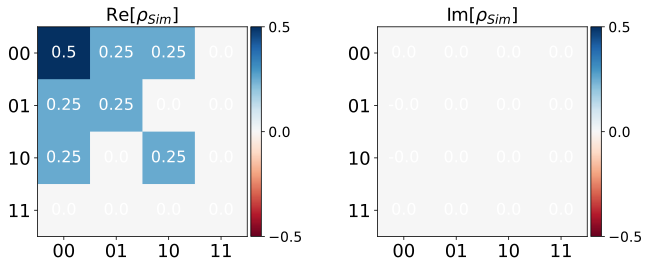

In [333]:
def ideal_rho(phi_I, phi_IS, phi_SL, phi_SR):

    rho = np.zeros((4, 4), dtype = 'complex')

    rho[0, 0] = 0.5
    rho[1, 1] = 0.25
    rho[2, 2] = 0.25

    rho[0, 1] = 1j*np.exp(1j*(phi_IS - phi_SR + phi_I))/4
    rho[0, 2] = 1j*np.exp(1j*(phi_IS - phi_SL + phi_I))/4

    rho[1, 0] = np.conj(rho[0, 1])
    rho[2, 0] = np.conj(rho[0, 2]) 

    rho = qt.Qobj(rho, dims=[[2, 2], [2, 2]])

    return rho 

rho_ideal = ideal_rho(phase_I, phase_IS, phase_SL, phase_SR)
show_plot_rho_2d(rho_sim=rho_ideal.full(), cmax=0.5)



### Generate pulse sequence

QCTRL pulses

In [13]:
from qctrl import Qctrl
from qctrlvisualizer import get_qctrl_style, plot_controls
qctrl = Qctrl()

Q-CTRL package update available.

Your version is 22.0.3. Latest version is 22.1.0.

Visit ]8;id=158088;https://boulder.q-ctrl.com/changelog\boulder.q-ctrl.com/changelog]8;;\ for the latest product updates.

In [154]:
# ctrl_result = qctrl.get_result(action_id=1760758)
# ctrl_result = qctrl.get_result(action_id=1761100) # 300 ns Q1 drive only, 16 input states
# ctrl_result = qctrl.get_result(action_id=1761543)
# ctrl_result = qctrl.get_result(action_id=1762374)
ctrl_result = qctrl.get_result(action_id=1763052)

  0%|          | 0/100 [00:00<?, ?it/s]

Fidelity: 0.9655697881205166


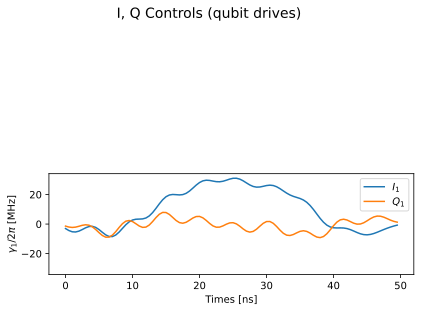

In [155]:
print("Fidelity:", 1-ctrl_result.output["cost"]["value"])

controls = []

control_times = []
I_values_pi = []
Q_values_pi = []
qubits_pi = []
for q in range(qram.nqubits):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    I_values_q = []
    Q_values_q = []
    t = 0
    for j in range(2): # I, Q
        name = f"$\gamma{'I' if j==0 else 'Q'}_{q}$"
        control = ctrl_result.output[name]
        for step, pulse in enumerate(control):
            if q==1 and j==0: control_times.append(t)
            t += pulse['duration']
            # factor of 1/2, -1, and 2pi due to how their controls are defined relative to ours
            if j==0: I_values_q.append(pulse['value'])
            else: Q_values_q.append(pulse['value'])

    # append to controls in same order as PICO/ALTRO pulses
    controls.append(-np.array(Q_values_q))
    controls.append(np.array(I_values_q))

    I_values_pi.append(I_values_q)
    Q_values_pi.append(Q_values_q)
    qubits_pi.append(q)

control_times = np.array(control_times)
I_values_pi = np.array(I_values_pi)
Q_values_pi = np.array(Q_values_pi)
qubits_pi = np.array(qubits_pi)

I_values = I_values_pi
Q_values = Q_values_pi
plt.figure(figsize=(6,8))
plt.suptitle('I, Q Controls (qubit drives)', fontsize=14)
ymax = 1.1*max(abs(np.concatenate((I_values.flatten(), Q_values.flatten()))))

controls_index = 0
for q in range(qram.nqubits):
    if f"$\gammaI_{q}$" not in ctrl_result.output: continue
    plt.subplot(int(f'41{q+1}'))
    plt.plot(control_times, 1e3*I_values[controls_index], label=f'$I_{q}$')
    plt.plot(control_times, 1e3*Q_values[controls_index], label=f'$Q_{q}$')
    plt.ylim(-1e3*ymax, 1e3*ymax)
    plt.ylabel(f'$\gamma_{q}/2\pi$ [MHz]')
    plt.legend()
    controls_index += 1


plt.xlabel('Times [ns]')
plt.tight_layout()
plt.show()

PICO pulses

<KeysViewHDF5 ['pulse', 'ts']>
(100, 8)


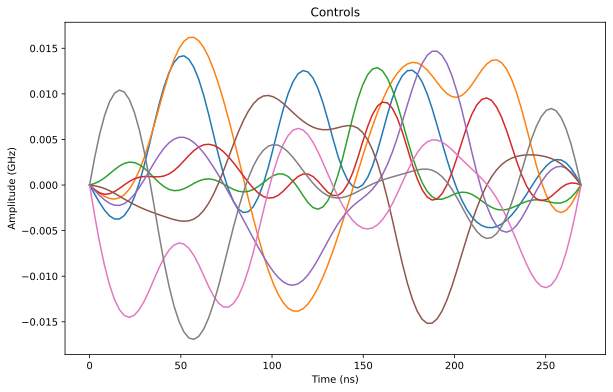

In [25]:
import h5py
# filename = 'C:/Users/slab/Downloads/pulse_single_drive_from_two_qubit_system_smoother.hdf5'
filename = 'pulse_all_drives_1.hdf5'
# filename = '../optimal_control/robust-pulses/out/qram/control_transmon_pi/00033_control_transmon_pi.h5'
h5 = h5py.File(filename,'r')
print(h5.keys())
controls = np.array(h5['pulse'])
control_times = np.array(h5['ts'])
print(controls.shape)
plt.plot(control_times, controls)
controls = controls.transpose()
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (GHz)')
plt.title('Controls')
plt.show()

Altro pulses

<KeysViewHDF5 ['Q', 'Qf', 'R', 'acontrols', 'al_tol', 'astates', 'cmax', 'cmax_info', 'constraint_tol', 'controls_idx', 'd2controls_dt2_idx', 'derivative_count', 'dt', 'evolution_time', 'hdim_iso', 'integrator_type', 'iterations', 'max_cost_value', 'max_iterations', 'max_penalty', 'pn_steps', 'save_type', 'solver_type', 'sqrtbp', 'transmon_state_count', 'ts']>
dt 1.6693376068376067 num steps 60
[25 26]
(52, 60)
(60,)
(2, 61)


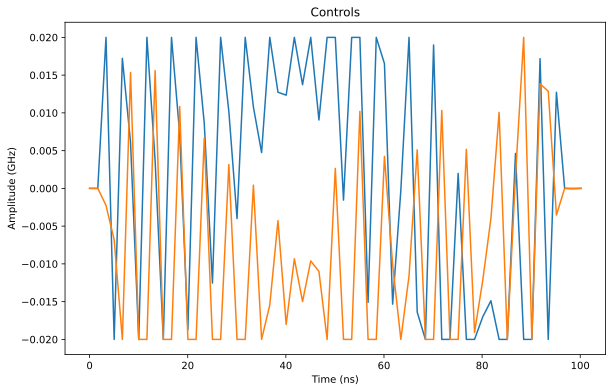

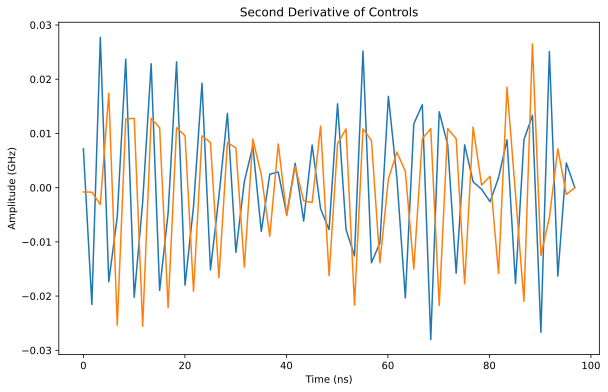

In [12]:
import h5py
filename = '../optimal_control/robust-pulses/out/qram/control_transmon_pi/00033_control_transmon_pi.h5'
h5 = h5py.File(filename,'r')
print(h5.keys())
controls_idx = np.array(h5['controls_idx'])
control_times = np.array(h5['ts'])
print('dt', control_times[1], 'num steps', len(control_times))
print(controls_idx)
print(np.array(h5['astates']).shape)
print(control_times.shape)
controls = np.array(h5['astates'][controls_idx[0]-1:controls_idx[1], :])/2/np.pi
controls = np.array([np.append(controls[0], [0]), np.append(controls[1], [0])])
control_times = np.append(control_times, [control_times[-1]+(control_times[1]-control_times[0])])
controls = np.array(controls)
print(controls.shape)
# for i in range(len(controls)):
#     for j in range(len(controls[0])):
#         controls[i,j] = min(controls[i,j], 0.02)
#         controls[i,j] = max(controls[i,j], -0.02)

plt.plot(control_times, controls[0])
plt.plot(control_times, controls[1])
# plt.ylim(-0.02, 0.02)
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (GHz)')
plt.title('Controls')
plt.show()

acontrols = np.array(h5['acontrols'])/2/np.pi
plt.plot(control_times[:-2], acontrols[0])
plt.plot(control_times[:-2], acontrols[1])
plt.xlabel('Time (ns)')
plt.ylabel('Amplitude (GHz)')
plt.title('Second Derivative of Controls')
plt.show()

import into pulse sequence

In [59]:
seq = PulseSequence(start_time=0)
wd = qram.get_base_wd('gggg', 'gegg')
print(wd/2/np.pi)
print(qubit_freqs[1])
# qram.add_precise_pi_pulse(seq, 'gggg', 'gegg', amp=0.015, mu=6, beta=4, drive_qubit=1, type='adiabatic', phase=0, t_pulse=120*4, wd=wd)
# qram.add_precise_pi_pulse(seq, 'gggg', 'gegg', amp=0.01, drive_qubit=1, type='gauss', sigma_n=4, phase=0)
# wd00 = qram.add_sequential_pi_pulse(seq, 'gggg', 'gegg', amp=0.01, drive_qubit=1, type='gauss', phase=-np.pi/2, pihalf=False)
seq.pulse_IQ(wd=wd, amp=1, pulse_levels=('gggg', 'gegg'), I_values=controls[1], Q_values=-controls[0], times=control_times, drive_qubit=1, t_start=0, phase=0)
# seq.pulse_IQ(wd=wd+2*np.pi*5e-3, amp=1, pulse_levels=('gggg', 'gegg'), I_values=controls[1], Q_values=-controls[0], times=times, drive_qubit=1, t_start=0, phase=np.pi/2)

3.455662041535801
3.46372489158


In [156]:
seq = PulseSequence(start_time=0)
for q in range(4):
    gstate = 'gggg'
    estate = gstate[:q]+'e'+gstate[q+1:]
    wd = qram.get_base_wd(gstate, estate)
    # wd = 2*np.pi*qram.qubit_freqs[q]
    if len(controls)//2 == 4: controls_q = [controls[2*q], controls[2*q+1]]
    else: controls_q = [controls[0], controls[1]]
    if len(controls)//2 == 4 or q==1:
        # seq.pulse_IQ(wd=wd, amp=1, pulse_levels=(gstate, estate), I_values=0*controls_q[1], Q_values=-0*controls_q[0], times=control_times, drive_qubit=q, t_start=0, phase=0)
        seq.pulse_IQ(wd=wd, amp=1, pulse_levels=(gstate, estate), I_values=controls_q[1], Q_values=-controls_q[0], times=control_times, drive_qubit=q, t_start=0, phase=0)
    # seq.pulse_IQ(wd=wd, amp=1, pulse_levels=(gstate, estate), I_values=controls_q[1], Q_values=controls_q[0], times=control_times, drive_qubit=q, t_start=0, phase=0)

In [19]:
seq = PulseSequence(start_time=0)

amp = 0.008
t_pulse = qram.get_Tpi('gggg', 'eggg', amp=amp, drive_qubit=0, type='gauss')

wd00 = qram.add_precise_pi_pulse(seq, 'gggg', 'eggg', amp=amp, t_pulse=t_pulse, drive_qubit=0, type='gauss', phase=0, sigma_n=4)
qram.add_precise_pi_pulse(seq, 'gggg', 'eggg', amp=amp, wd=wd00, t_pulse=t_pulse, drive_qubit=1, type='gauss', phase=0, t_offset=-seq.get_pulse_lengths()[-1], sigma_n=4)
qram.add_precise_pi_pulse(seq, 'gggg', 'eggg', amp=amp, wd=wd00, t_pulse=t_pulse, drive_qubit=2, type='gauss', phase=0, t_offset=-seq.get_pulse_lengths()[-1], sigma_n=4)
qram.add_precise_pi_pulse(seq, 'gggg', 'eggg', amp=amp, wd=wd00, t_pulse=t_pulse, drive_qubit=3, type='gauss', phase=0, t_offset=-seq.get_pulse_lengths()[-1], sigma_n=4)


	new overlap 0.9995983546667213 wd 26.041179461640255 wd_res 0.25
updated drive freq (GHz) from 4.144582435263189 to 4.144582435263189


26.041179461640255

In [27]:
seq = PulseSequence(start_time=0)


# ---- PREPARE Q1 and Q2

# # |0>|0+1>
# wd01 = qram.add_sequential_pi_pulse(seq, 'gggg', 'gegg', amp=amp_pi_2, drive_qubit=1, type='gauss', phase=-np.pi/2, pihalf=True)

# # |1>|0+1>
# wd00 = qram.add_sequential_pi_pulse(seq, 'gggg', 'eggg', amp=amp_pi_2, drive_qubit=0, type='gauss', phase=0, pihalf=False)
# wd01 = qram.add_sequential_pi_pulse(seq, 'eggg', 'eegg', amp=amp_pi_2, drive_qubit=1, type='gauss', phase=-np.pi/2, pihalf=True)

# |0+1>|0+1>
phase_I = -np.pi/2
wd00 = qram.add_sequential_pi_pulse(seq, 'gggg', 'eggg', amp=amp_pi_2, drive_qubit=0, type='gauss', phase=-np.pi/2, pihalf=True)
wd01_1 = qram.get_wd('eggg', 'eegg', amp=amp_pi_2_2, drive_qubit=1, verbose=True)
Tpi_1 = qram.get_Tpi('eggg', 'eegg', amp=amp_pi_2_2, drive_qubit=1, type='gauss')
wd01_2 = qram.get_wd('gggg', 'gegg', amp=amp_pi_2_2, drive_qubit=1, verbose=True)
Tpi_2 = qram.get_Tpi('gggg', 'gegg', amp=amp_pi_2_2, drive_qubit=1, type='gauss')
wd01 = qram.add_sequential_pi_pulse(seq, 'eggg', 'eegg', amp=amp_pi_2_2, t_pulse=(Tpi_1+Tpi_2)/2/2, drive_qubit=1, type='gauss', phase=phase_I, pihalf=True, wd=np.average((wd01_1, wd01_2)))

# # |0+i1>|0+1>
# phase_I = -np.pi
# wd00 = qram.add_sequential_pi_pulse(seq, 'gggg', 'eggg', amp=amp_pi_2, drive_qubit=0, type='gauss', phase=phase_I, pihalf=True)
# wd01_1 = qram.get_wd('eggg', 'eegg', amp=amp_pi_2_2, drive_qubit=1, verbose=True)
# wd01_2 = qram.get_wd('gggg', 'gegg', amp=amp_pi_2_2, drive_qubit=1, verbose=True)
# wd01 = qram.add_sequential_pi_pulse(seq, 'eggg', 'eegg', amp=amp_pi_2_2, drive_qubit=1, type='gauss', phase=-np.pi/2, pihalf=True, wd=np.average((wd01_1, wd01_2)))


# ---- FORWARD PROTOCOL ---- 

# First swap
print('w_swap_0')
w_swap_0 = qram.get_wd('eggg', 'gfgg', amp=amp_swap_01, drive_qubit=1, verbose=True)
wd0 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=amp_swap_01, drive_qubit=1, phase=phase_IS, wd=w_swap_0)

print('w_swap_1')
w_swap_1 = qram.get_wd('gfgg', 'ggeg', amp=amp_swap_12, drive_qubit=1, verbose=True)
wd1 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=amp_swap_12, drive_qubit=1, phase=phase_SL, wd=w_swap_1)
print('wd2')

#  Second swap
print('w_pi')
wd2_1 = qram.get_wd('eegg', 'eggg', amp=amp_pi, drive_qubit=1, verbose=True)
wd2_2 = qram.get_wd('ggeg', 'geeg', amp=amp_pi, drive_qubit=1, verbose=True)
wd2_3 = qram.get_wd('gegg', 'gggg', amp=amp_pi, drive_qubit=1, verbose=True)
wd2 = qram.add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=amp_pi, drive_qubit=1, 
                                   wd=np.average((wd2_1, wd2_2, wd2_3)), type='gauss', phase=0)

print('w_swap_2')
wd3 = qram.add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=amp_swap_01, drive_qubit=1, wd=w_swap_0, phase=phase_IS)

print('w_swap_3')
wd4 = qram.add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=amp_swap_13, drive_qubit=1, phase=phase_SR)

print('w_pi')
wd5_1 = qram.get_wd('ggge', 'gege', amp=amp_pi, drive_qubit=1, verbose=True)
wd5_2 = qram.get_wd('geeg', 'ggeg', amp=amp_pi, drive_qubit=1, verbose=True)
wd5_3 = qram.get_wd('gegg', 'gggg', amp=amp_pi, drive_qubit=1, verbose=True)
wd5 = qram.add_sequential_pi_pulse(seq, 'ggge', 'gege', amp=amp_pi, 
                                   drive_qubit=1, wd=np.average((wd5_1, wd5_2, wd5_3)), type='gauss', phase=0)


print('Done.')

	new overlap 0.9993724562311568 wd 26.04117946164027 wd_res 0.25
updated drive freq (GHz) from 4.144582435263191 to 4.144582435263191
	new overlap 0.996674824145231 wd 21.680567040450406 wd_res 0.25
updated drive freq (GHz) from 3.450569413522906 to 3.450569413522906
	new overlap 0.996815625947961 wd 21.71267498801057 wd_res 0.25
updated drive freq (GHz) from 3.4556795520896415 to 3.4556795520896415
w_swap_0
	new overlap 0.7899494892441005 wd 16.76417650965965 wd_res 0.25
	new overlap 0.7899494892441005 wd 16.76417650965965 wd_res 0.05
	new overlap 0.9845581599981574 wd 16.754176509659647 wd_res 0.005
	new overlap 0.9885252918654467 wd 16.75517650965965 wd_res 0.001
	new overlap 0.9885744016746456 wd 16.75497650965965 wd_res 0.0002
	new overlap 0.988605905761851 wd 16.75505650965965 wd_res 4e-05
	new overlap 0.988605905761851 wd 16.75505650965965 wd_res 8.000000000000001e-06
updated drive freq (GHz) from 2.66810155837737 to 2.666650065296372
w_swap_1
	new overlap 0.8238285924151989 wd 

In [111]:
# CHECK FOR CLASHING LEVELS
tolerance = 100*MHz
problem_pulses = qram.check_level_resonances(seq, tolerance=tolerance)
good_freqs = seq.get_pulse_freqs(simplified=True)
print(good_freqs)
if len(problem_pulses.items()) == 0:
    print(f'No clashes found within {tolerance} GHz!')
for good_pulse, problem_pulse_dict in problem_pulses.items():
    print('Clashes to', tolerance,'GHz with', good_pulse[0], '<->', good_pulse[1], f'(freq = {good_freqs[good_pulse]})', 'tpi', qram.get_Tpi(good_pulse[0], good_pulse[1], amp=0.05))
    for problem_pulse, freq in problem_pulse_dict.items():
        diff_freq = np.abs(freq)-np.abs(good_freqs[good_pulse])
        if np.abs(diff_freq) > tolerance:
            diff_freq = 2*np.abs(freq)-np.abs(good_freqs[good_pulse])
        print('\t', 'GOOD PULSE' if problem_pulse in good_freqs.keys() else '', problem_pulse[0], '<->', problem_pulse[1], freq, f'(off by {diff_freq*1e3} MHz)', 'tpi', qram.get_Tpi(problem_pulse[0], problem_pulse[1], amp=0.05))

{('eggg', 'gggg'): 4.144585866376248, ('eegg', 'eggg'): 3.455383606614622, ('eggg', 'gfgg'): 2.667447808234876, ('gfgg', 'ggeg'): 2.0089503481432147, ('gfgg', 'ggge'): 2.394564699713925, ('gege', 'ggge'): 3.4642280305116766}
Clashes to 0.1 GHz with eegg <-> eggg (freq = 3.455383606614622) tpi 10.12120725132859
	 GOOD PULSE gege <-> ggge 3.4642280305116766 (off by 8.844423897054643 MHz) tpi 10.056072934180653
Clashes to 0.1 GHz with gege <-> ggge (freq = 3.4642280305116766) tpi 10.056072934180653
	 GOOD PULSE eegg <-> eggg 3.455383606614622 (off by -8.844423897054643 MHz) tpi 10.12120725132859


In [143]:
import scqubits as sc
EC = 0.280
EJ = 3.470**2/8/EC
print(EJ, EC, EJ/EC)
transmon = sc.Transmon(EJ=EJ, EC=EC, ng=0, ncut=31)

5.375401785714286 0.28 19.197863520408163


(3.1503518059021935, 3.170351805902193)

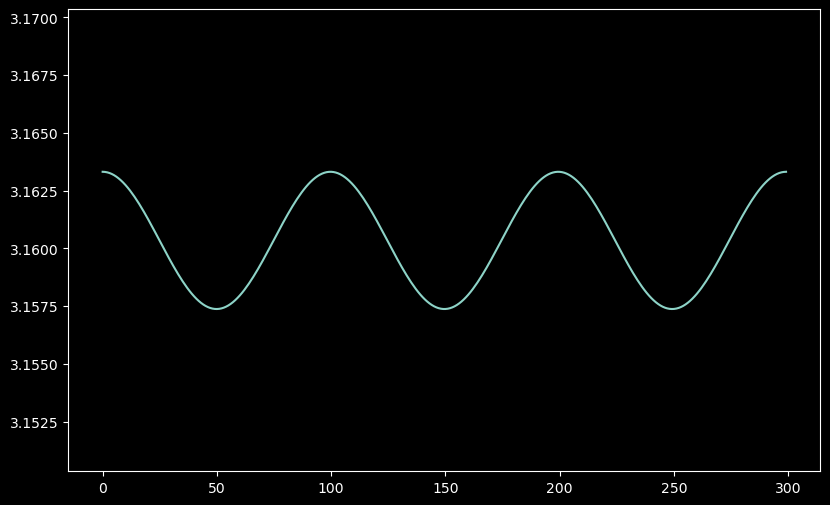

In [144]:
ng_vals = np.linspace(0, 3, 300)

data = transmon.get_spectrum_vs_paramvals('ng', ng_vals, evals_count=6, subtract_ground=False, get_eigenstates=True, filename=None, num_cpus=None)
ge_freq = data.energy_table[:,1] - data.energy_table[:,0]
plt.plot(ge_freq)
plt.ylim(np.average(ge_freq)-0.01, np.average(ge_freq) + 0.01)
# data.plot_evals_vs_paramvals(which=[0, 1],subtract_ground=True)

### Plot pulse seq envelopes

[3.452638640226737] (GHz)
[49.5] (ns)
total pulse length 49.5 ns


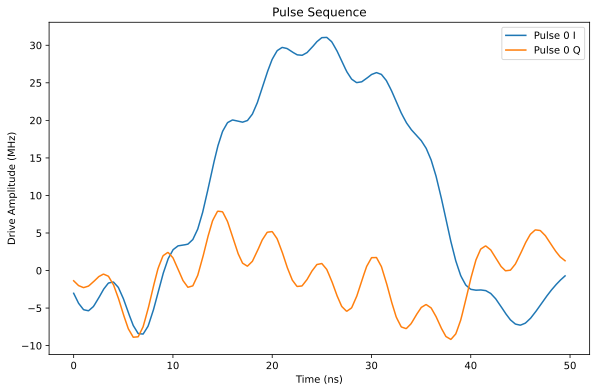

In [157]:
envelope_seq = seq.get_envelope_seq()
pulse_amps = seq.get_pulse_amps()
pulse_freqs = seq.get_pulse_freqs()
pulse_lens = seq.get_pulse_lengths()
drive_funcs = seq.get_pulse_seq()
print(seq.get_pulse_freqs(), '(GHz)')
print(pulse_lens, '(ns)')
print('total pulse length', sum(seq.get_pulse_lengths()), 'ns')

# times = []
# tot_time = 0
# for pulse_len in pulse_lens:
#     # times.append(np.linspace(tot_time, tot_time + pulse_len, 100))
#     nsteps = 50
#     dt = pulse_len/nsteps
#     if dt > 5: nsteps = int(pulse_len // 10)
#     times = np.append(times, np.linspace(tot_time, tot_time + pulse_len, nsteps))
#     tot_time = tot_time + pulse_len
# print('num time points', len(times))

# times = np.linspace(0, sum(seq.get_pulse_lengths())+10, 900)
# times = np.linspace(0, sum(seq.get_pulse_lengths())+30, 200)
# times = np.linspace(0, sum(seq.get_pulse_lengths()), 50)
times = np.linspace(0, seq.get_pulse_lengths()[-1], 900)

flat_times = np.array(times).flatten()
# drive_v_times = []
envelope_v_times = []
for i in range(len(envelope_seq)):
    if isinstance(envelope_seq[i], list) and len(envelope_seq[i]) == 2:
        envelope_v_time_I = [pulse_amps[i]*envelope_seq[i][0](t)/MHz for t in flat_times]
        envelope_v_time_Q = [pulse_amps[i]*envelope_seq[i][1](t)/MHz for t in flat_times]
        plt.plot(flat_times, envelope_v_time_I, label=f'Pulse {i} I')
        plt.plot(flat_times, envelope_v_time_Q, label=f'Pulse {i} Q')
    else:
        envelope_v_time = [pulse_amps[i]*envelope_seq[i](t)/MHz for t in flat_times]
        envelope_v_times.append(envelope_v_time)
        plt.plot(flat_times, envelope_v_time, label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
# plt.xlim(0, 100)
plt.title('Pulse Sequence')
plt.legend()
plt.show()

## Run simulation

In [12]:
T1 = 60e3 # ns
T2 = 30e3 # ?

# T1 = 10e3

# c_ops = [
#     np.sqrt(1/T1)*qram.a,
#     np.sqrt(1/T1)*qram.b,
#     np.sqrt(1/T1)*qram.c,
#     np.sqrt(1/T1)*qram.d,
# ]

c_ops = None

Make extended qram state given 2q tomo result (e.g. from experiment) - assumes all other states are 0

In [20]:
exptpsi0 = np.array(
[[ 0.28 +0.j,    -0.052+0.118j,  0.162-0.116j, -0.08 -0.028j],
 [-0.052-0.118j,  0.265+0.j,     0.023+0.02j,  -0.154+0.077j],
 [ 0.162+0.116j,  0.023-0.02j,   0.276+0.j,    -0.093-0.02j ],
 [-0.08 +0.028j, -0.154-0.077j, -0.093+0.02j,   0.18 +0.j   ]])

exptpsi0 = np.array(
[[0.25, 0.25, 0.25, 0.25],
 [0.25, 0.25, 0.25, 0.25],
 [0.25, 0.25, 0.25, 0.25],
 [0.25, 0.25, 0.25, 0.25]] 
)

psi0 = 0*qt.ket2dm(qram.state('gggg'))
for i in range(len(exptpsi0)):
    for j in range(len(exptpsi0[0])):
        iq0 = i // 2
        iq1 = i % 2
        jq0 = j // 2
        jq1 = j % 2
        # print(iq0, iq1, jq0, jq1, exptpsi0[i,j])
        psi0 += exptpsi0[i, j] * qram.make_bare((iq0, iq1, 0, 0)) * qram.make_bare((jq0, jq1, 0, 0)).dag()
psi0 = psi0.unit()
# print(psi0)
# print(gggg)
# np.abs([gggg.dag()*psi0*gggg])

SIMULATE

In [161]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'efgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

# psi0 = qram.state(psi0_name)
# psi0 = qram.state('eggg')
# psi0 = (qram.state('gggg') + qram.state('gegg')).unit()
psi0 = (qram.state('eggg') + 1j*qram.state('eegg')).unit()
# psi0 = (qram.state('eggg', esys=esys_rot_wd) + 1j*qram.state('eegg', esys=esys_rot_wd)).unit()
# psi0 = (qram.make_bare('eggg') + 1j*qram.make_bare('eegg')).unit()
# psi0 = (qram.state('ggeg') + qram.state('geeg')).unit()
# psi0 = (qram.state('ggge') + qram.state('gege')).unit()
# psi0 = np.sqrt(0.5) * qram.state('gegg') + np.sqrt(0.5) * qram.state('eegg') # QRAM start |0+1>|1>
# psi0 = np.sqrt(0.5) * qram.state('eggg') + np.sqrt(0.5) * qram.state('eegg') # QRAM start |1>|0+1>
# psi0 = np.sqrt(0.5) * qram.state('gggg') + np.sqrt(0.5) * qram.state('gegg') # QRAM start |0>|0+1>
# psi0 = (qram.state('eggg') + qram.state('eegg') + qram.state('gggg') + qram.state('gegg')).unit() # QRAM start |0+1>|0+1>
# psi0 = (1j*qram.state('eggg') + 1j*qram.state('eegg') + qram.state('gggg') + qram.state('gegg')).unit() # QRAM start |0+i1>|0+1>

# result_lab = qram.evolve(psi0, seq, times, c_ops=None, nsteps=20000, use_str_solve=False)
# result = qram.evolve_rot_frame(psi0, seq, times, c_ops=None, nsteps=20000)

result_lab = qt.mesolve(qram.H_solver_rot_wd(seq=seq, wframe=qram.get_base_wd('gggg', 'gegg')), psi0, times, progress_bar=True, options=qt.Options(nsteps=1000)).states

10.0%. Run time:   0.14s. Est. time left: 00:00:00:01
20.0%. Run time:   0.29s. Est. time left: 00:00:00:01
30.0%. Run time:   0.43s. Est. time left: 00:00:00:00
40.0%. Run time:   0.56s. Est. time left: 00:00:00:00
50.0%. Run time:   0.70s. Est. time left: 00:00:00:00
60.0%. Run time:   0.84s. Est. time left: 00:00:00:00
70.0%. Run time:   0.97s. Est. time left: 00:00:00:00
80.0%. Run time:   1.11s. Est. time left: 00:00:00:00
90.0%. Run time:   1.24s. Est. time left: 00:00:00:00
Total run time:   1.38s


In [236]:
esys_rot_wd = qram.H_rot(wd=qram.get_base_wd('gggg', 'gegg')).eigenstates()
evals, evecs = esys_rot_wd
def unrotate(result, t):
    # return result
    result_rot = 0*result
    evals, evecs = esys_rot_wd
    for eval, evec in zip(evals, evecs):
        # |a> = sum_i(|biXbi|a>), a.overlap(b) = <a|b>
        evec_flat = evec.full().flatten()
        overlap = np.sum(np.conj(evec_flat) * result.full().flatten())
        # print(eval)
        result_rot += np.exp(1j*eval*t) * overlap * evec
    return result_rot
result = [unrotate(result_lab[-1], times[-1])]

3.4556657887229973 3.4256657887229975 3.485665788722997


100%|██████████| 100/100 [1:22:29<00:00, 49.50s/it]


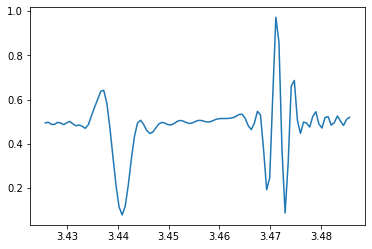

In [ ]:
wd_span = 0.060*2*np.pi # GHz
npts = 100

wd = qram.get_base_wd('gggg', 'gegg')
print(wd/2/np.pi, (wd-wd_span/2)/2/np.pi, (wd+wd_span/2)/2/np.pi)
wd_sweep = np.linspace(wd-wd_span/2, wd+wd_span/2, npts)
psi0 = (qram.state('gggg') + qram.state('gegg')).unit() # QRAM start |0>|0+1>
gegg = qram.state('gegg')
eegg = qram.state('eegg')
geeg = qram.state('geeg')
gege = qram.state('gege')
probs_q1e = []
for wd in tqdm(wd_sweep):
    seq = PulseSequence(start_time=0)
    qram.add_precise_pi_pulse(seq, 'gggg', 'gegg', amp=0.015, mu=6, beta=4, drive_qubit=1, type='adiabatic', phase=0, t_pulse=120*4, wd=wd)
    times = np.linspace(0, sum(seq.get_pulse_lengths()), 30)
    result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=50000, use_str_solve=False, progress=False)[-1]
    prob_q1e = np.abs(gegg.overlap(result))**2 + np.abs(eegg.overlap(result))**2 + np.abs(geeg.overlap(result))**2 + np.abs(gege.overlap(result))**2
    probs_q1e.append(prob_q1e)
plt.plot(wd_sweep/2/np.pi, probs_q1e)
plt.show()

In [162]:
# result = [result_lab_t.unit() for result_lab_t in result_lab]
result = result_lab

In [110]:
result = qram.evolve_unrotate(times=times, result=result_lab)
# result = qram.evolve_unrotate(times=[times[-1]], result=[result_lab[-1]])

100%|██████████| 900/900 [00:46<00:00, 19.38it/s]


Iterate over pulse detuning

In [ ]:
wd = qram.get_base_wd('gggg', 'gegg')
detunings = np.linspace(0, 5e-3, num=25)
gggg = qram.state('gggg')
gegg = qram.state('gegg')
psi0 = (gggg + gegg).unit()
phases = []
for idet, detune in enumerate(tqdm(detunings)):
    seq = PulseSequence(start_time=0)
    seq.pulse_IQ(wd=wd + 2*np.pi*detune, amp=1, pulse_levels=('gggg', 'gegg'), I_values=controls[1], Q_values=-controls[0], times=control_times, drive_qubit=1, t_start=0, phase=0)
    times = np.linspace(0, sum(seq.get_pulse_lengths()), 50)
    result = qram.evolve(psi0, seq, times, c_ops=None, nsteps=20000, use_str_solve=False, progress=False)
    psif = result[-1]
    phase = psif.overlap(gegg) / psif.overlap(gggg)
    phase /= abs(phase)
    try: phase = np.arctan(np.imag(phase) / np.real(phase))
    except ZeroDivisionError: phase = np.pi/2
    if idet == 0:
        phase0 = phase
        print('phase 0:', phase0)
    phase -= phase0
    phases.append(phase)

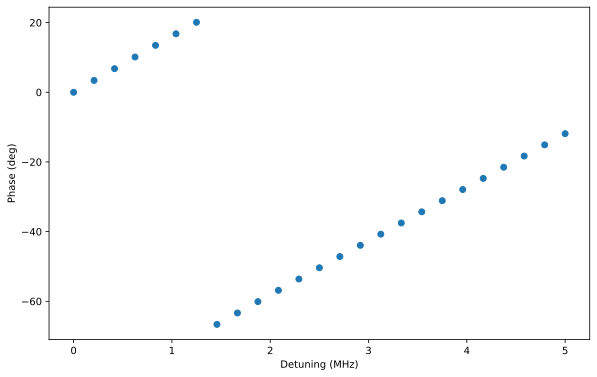

In [412]:
plt.plot(detunings*1e3, np.array(phases)/2/np.pi*180, 'o')
plt.ylabel('Phase (deg)')
plt.xlabel('Detuning (MHz)')
plt.show()

Iterate over pulse amplitude

In [ ]:
wd = qram.get_base_wd('gggg', 'gegg')
IQscale = max(np.max(np.abs(controls_q[0])), np.max(np.abs(controls_q[1])))
amps = np.linspace(0, 2*IQscale, num=100)
gggg = qram.state('gggg')
gegg = qram.state('gegg')
# psi0 = (gggg + gegg).unit()
psi0 = gggg
plot_states = ['eggg', 'gfgg', 'ggeg', 'eegg', 'ggge', 'geeg', 'gege', 'gggg', 'gegg', 'efgg'] #, 'ehgg', 'ghgg']
results_amps = []
for iamp, amp in enumerate(tqdm(amps)):
    seq = PulseSequence(start_time=0)
    seq.pulse_IQ(wd=wd, amp=amp, pulse_levels=('gggg', 'gegg'), I_values=controls[1]/IQscale, Q_values=-controls[0]/IQscale, times=control_times, drive_qubit=1, t_start=0, phase=0)
    # times = np.linspace(control_times[0], control_times[-1], 50)
    times = control_times
    result = qt.mesolve(qram.H_solver_rot_wd(seq=seq, wframe=qram.get_base_wd('gggg', 'gegg')), psi0, times, progress_bar=None, options=qt.Options(nsteps=1000)).states
    results_amps.append(result[-1])

prob_states = dict()
for state in plot_states:
    psi = qram.state(state)
    prob_states.update({state:[np.abs(psi.overlap(results_amps[i_amp]))**2 for i_amp in range(len(amps))]})

for state in plot_states:
    plt.plot(amps*1e3, prob_states[state], label=rf'$|{state}\rangle_D$')

plt.legend(fontsize=10, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Amps (MHz)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)

Save result state

In [ ]:
# import sys
# orig_stdout = sys.stdout
# with open('forward_protocol_input0plusi1_switch5050.txt', 'w') as f:
#     sys.stdout = f
#     print(result)
#     sys.stdout = original_stdout
print(result)

In [355]:
result_dict = dict()

In [372]:
result_dict.update({'|1>|0+1>':result})

In [406]:
result = result_dict['|0+i1>|0+1>']

Plot evolution results

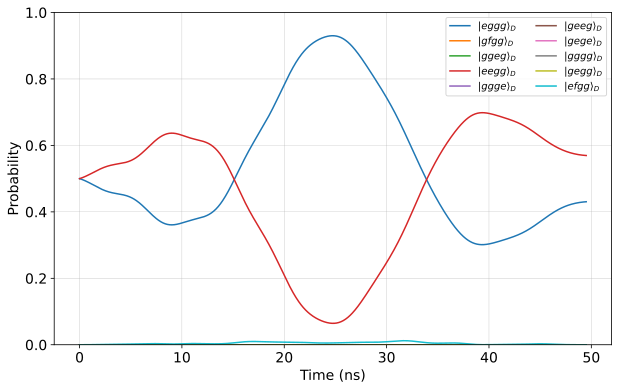

In [163]:
saveplot = False

plt.figure(figsize=(10,6))
if saveplot: plt.style.use('dark_background')

# states for 1 input
# plot_states = ['eggg', 'gfgg', 'ggeg', 'eegg', 'ggge', 'geeg', 'gege', 'gggg', 'gegg']
plot_states = ['eggg', 'gfgg', 'ggeg', 'eegg', 'ggge', 'geeg', 'gege', 'gggg', 'gegg', 'efgg'] #, 'ehgg', 'ghgg']
prob_states = dict()
for state in plot_states:
    psi = qram.state(state)
    prob_states.update({state:[np.abs(psi.overlap(result[t]))**2 for t in range(len(times))]})

for state in plot_states:
    plt.plot(times, prob_states[state], label=rf'$|{state}\rangle_D$')

plt.legend(fontsize=10, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=14)
plt.ylabel('Probability', fontsize=14)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)

if saveplot:
    plot_filename = 'qram_protocol_simulated.png'
    plt.savefig(plot_filename, format='png', bbox_inches='tight', transparent = True)
    print('Saved', plot_filename)

plt.show()

Get non zero levels

In [42]:
max_prob = 0.001

T = times[-1] # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
probs = dict()
print(f"Non-zero levels to {max_prob*100}% error:")
for i1 in range(cutoffs[0]):
    for i2 in range(cutoffs[1]):
        for i3 in range(cutoffs[2]):
            for i4 in range(cutoffs[3]):
                prob = np.abs(qram.state([i1, i2, i3, i4]).overlap(result[T]))**2
                if prob > max_prob:
                    probs.update({qram.level_nums_to_name([i1, i2, i3, i4]):prob})
                    sum_psi += prob
probs = sorted(probs.items(), key=lambda item:-item[1])
for level, prob in probs:
    print(level, '(%):', prob*100)
print('Sum probabilities (%):', sum_psi*100)

Non-zero levels to 0.1% error:
eggg (%): 45.573801607496236
eegg (%): 42.71537480066547
efgg (%): 11.703629082885348
Sum probabilities (%): 99.99280549104706


Max fidelity [%]: 99.99999999999997
Final fidelity [%]: 9.695354809738618


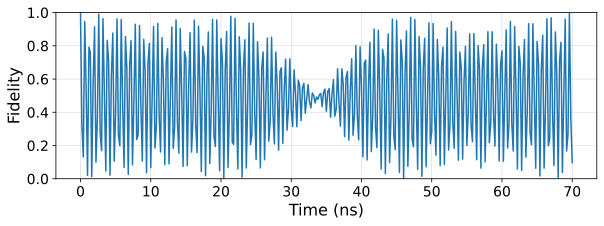

In [ ]:
# ket_target = qram.state('ggeg')
ket_target = (qram.state('gegg') + qram.state('gggg')).unit()
qram.fidelity(qram.state('ggeg'), result[-1])
qram.fidelity(qram.state('gege'), result[-1])

fidelities = [qram.fidelity(ket_target, result[t]) for t in range(len(times))]
print(f'Max fidelity [%]: {1e2*max(fidelities)}')
print(f'Final fidelity [%]: {1e2*fidelities[-1]}')

plt.figure(figsize=(9.7,3))
plt.plot(times, fidelities)

# plt.legend(fontsize=16, ncol=2)
plt.ylim(0, 1)
# plt.xlim(750, 1000)
plt.tick_params(labelsize=14)
plt.xlabel('Time (ns)', fontsize=16)
plt.ylabel('Fidelity', fontsize=16)
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
# plt.title('QRAM state evolution in memory access operation')
plt.grid(linewidth=0.3)
plt.show()

## Truncate result so it's compatible with 2q tomography

Get ideal rho

In [98]:
psi0 = 'e(g+ie)gg'
result = [qt.Qobj(ctrl_result.output[psi0]['value'][t], dims = [[3, 3, 3, 3], [1, 1, 1, 1]], shape = (81, 1)) for t in range(len(ctrl_result.output[psi0]['value']))]

In [164]:
psiZ = [qt.basis(2,0), qt.basis(2,1)]
psi00 = qt.tensor(psiZ[0], psiZ[0])
psi01 = qt.tensor(psiZ[0], psiZ[1])
psi10 = qt.tensor(psiZ[1], psiZ[0])
psi11 = qt.tensor(psiZ[1], psiZ[1])

rho_ids = dict()
rho_ids.update({'|0>|0+1>':qt.ket2dm(psi00).unit()})
rho_ids.update({'|1>|0+1>':(qt.ket2dm(psi10) + qt.ket2dm(psi01)).unit()})
rho_ids.update({'|0+1>|0+1>':(qt.ket2dm(psi00 + psi10) + qt.ket2dm(psi00 + psi01)).unit()})
rho_ids.update({'|0+i1>|0+1>':(qt.ket2dm(psi00 + 1j*psi10) + qt.ket2dm(psi00 + 1j*psi01)).unit()})

rho_id = rho_ids['|0+1>|0+1>']

# rho_id = qt.ket2dm(qt.tensor(psiZ[0]+psiZ[1], psiZ[0]+psiZ[1])).unit()
rho_id = qt.ket2dm(psi10 - 1j*psi11).unit()
# rho_id = qt.ket2dm(psi00 + psi01 + psi10 + psi11).unit()
# rho_id = qt.ket2dm(psi11).unit()

Get 2Q partial trace density matrix

Quantum object: dims = [[4, 5], [4, 5]], shape = (20, 20), type = oper, isherm = True
Qobj data =
[[ 3.53375718e-04+1.89752902e-21j -4.40942968e-06+4.07382967e-04j
  -5.22748634e-07-8.11938910e-06j -1.19780510e-06+1.11267051e-07j
   5.75762750e-07+2.02706341e-06j -7.82194658e-05+7.67473647e-04j
   5.62571779e-05-9.56137487e-05j  4.82258312e-07+2.65907870e-06j
   1.80939642e-08-4.27686953e-07j  6.22038563e-09-8.48128140e-09j
  -9.40320398e-06+1.59087013e-05j -1.43631015e-07-4.11773985e-07j
  -1.67652752e-09+6.88010563e-08j -3.66832185e-08-3.16053920e-08j
   1.51255501e-09+4.19860638e-09j  4.21362062e-08+3.77865222e-08j
  -2.21442445e-09-9.57482787e-09j  1.04276283e-08+9.51469860e-09j
  -1.75818466e-09-2.92467760e-09j  2.87535489e-11+1.65876842e-10j]
 [-4.40942968e-06-4.07382967e-04j  3.12976698e-03+9.54667896e-20j
   1.48888267e-05+3.73080811e-03j  1.10856017e-06-8.92906851e-06j
   4.50761542e-06+7.81032396e-06j  3.45933847e-02+9.84160472e-05j
   1.33935461e-04+3.80140418e-02j  1.660889

 C:\Users\slab\AppData\Local\Temp\ipykernel_11836\2539742270.py: 21UserWarning: The figure layout has changed to tight
 C:\Users\slab\AppData\Local\Temp\ipykernel_11836\2539742270.py: 48

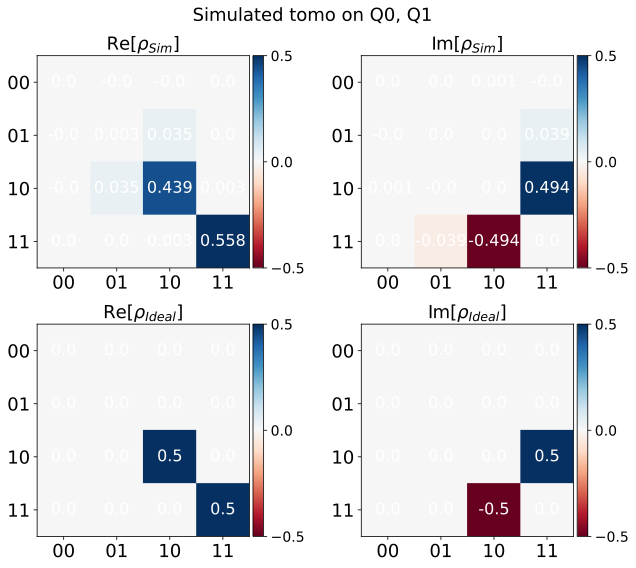

Fidelity: 0.9917416076144482
Purity (sim): 0.9962338771205446
Purity (ideal): 1.0


In [165]:
# print(result[-1].dims)
tomo_qubits = [0, 1]
# tomo_qubits = [2, 3]
# tomo_qubits = [1, 2]
# tomo_qubits = [1, 3]
result2q = qt.ptrace(result[-1].unit(), tomo_qubits)
# result2q = qt.ptrace(psi0, tomo_qubits)
orig_dims = result2q.dims[0]
# result2q = qt.ptrace(result.unit(), tomo_qubits)
# print('orig dims', orig_dims)
# rho_result2q = result2q
print(result2q)

states_inds = [i*orig_dims[1]+ j for i in range(2) for j in range(2)]
# print('extract state indices', states_inds)
rho_result2q = result2q.extract_states(states_inds, normalize=True)


id2q = qt.tensor(qt.qeye(2), qt.qeye(2))
rho_result2q  = qt.Qobj(rho_result2q , dims=id2q.dims, shape=id2q.shape).unit()
print(rho_result2q)

show_plot_rho_2d(rho_sim=rho_result2q.full(), rho_id=rho_id.full(), title=f'Simulated tomo on Q{tomo_qubits[0]}, Q{tomo_qubits[1]}', cmax=0.5) #, savetitle='0_0+1_simulated_flat.png') #, cmax=1.0)

fid = qt.fidelity(rho_result2q, rho_id)**2 # qutip uses N&C fidelity which is "sqrt fidelity"
purity_sim = np.real(np.trace(rho_result2q.full() @ rho_result2q.full()))
purity_id = np.real(np.trace(rho_id.full() @ rho_id.full()))
print(f'Fidelity: {fid}')
print(f'Purity (sim): {purity_sim}')
print(f'Purity (ideal): {purity_id}')

Define virtual Z gate optimization 

In [55]:
def z_gate_2q(phi1, phi2):
    return qt.tensor(qt.qip.operations.gates.rz(phi1), qt.qip.operations.gates.rz(phi2)) 

# The simulation density matrix from MLE may be offset from the ideal density matrix by a Z gate - due to different pulse times, ac stark shifts, etc. Rotate rho_rot to best match rho_target
def opt_virtualZ_MLE(rho0, rho_target, nphi=100, phi_mins=[0]*2, phi_maxs=[2*np.pi]*2):
    phis1 = np.linspace(phi_mins[0], phi_maxs[0], nphi)
    phis2 = np.linspace(phi_mins[1], phi_maxs[1], nphi)
    best_fid = qt.fidelity(rho0, rho_target)**2
    all_fids = []
    best_phis = [0, 0]
    best_rho_rot = rho0
    for phi1 in tqdm(phis1):
        for phi2 in phis2:
            z_phi12 = z_gate_2q(phi1, phi2)
            rho_rot = (z_phi12*rho0*z_phi12.dag()).unit()
            fid = qt.fidelity(rho_rot, rho_target)**2
            all_fids.append(fid)
            # print(fid)
            if fid > best_fid:
                best_fid = fid
                best_phis = [phi1, phi2]
                best_rho_rot = rho_rot
    print(f'Improved fidelity by (%) {(best_fid - qt.fidelity(rho0, rho_target)**2)*100}')
    all_fids = np.array(all_fids)
    all_fids = np.reshape(all_fids, (nphi, nphi))
    return best_rho_rot, best_phis, best_fid, all_fids

Optimize over virtual Z gates

In [105]:
rho_result2q = qt.Qobj(inpt=np.array( # |1>|0+1> input, forward simulation smaller amps, averaged pi pulses, q2/q3
[[ 0.592+0.j   , -0.008-0.172j, -0.201+0.033j, -0.011+0.014j],
 [-0.008+0.172j,  0.285+0.j   , -0.045-0.005j, -0.017-0.017j],
 [-0.201-0.033j, -0.045+0.005j,  0.094+0.j   , -0.008+0.005j],
 [-0.011-0.014j, -0.017+0.017j, -0.008-0.005j,  0.028+0.j   ]]),
                 dims=rho_id.dims, shape=rho_id.shape)

100%|██████████| 25/25 [00:02<00:00, 11.73it/s]


Improved fidelity by (%) 4.661146227519108
Fidelity (after rotation round 1): 0.7625017871599762
Best rotation round 1: [0.7853981633974483, 5.759586531581287]


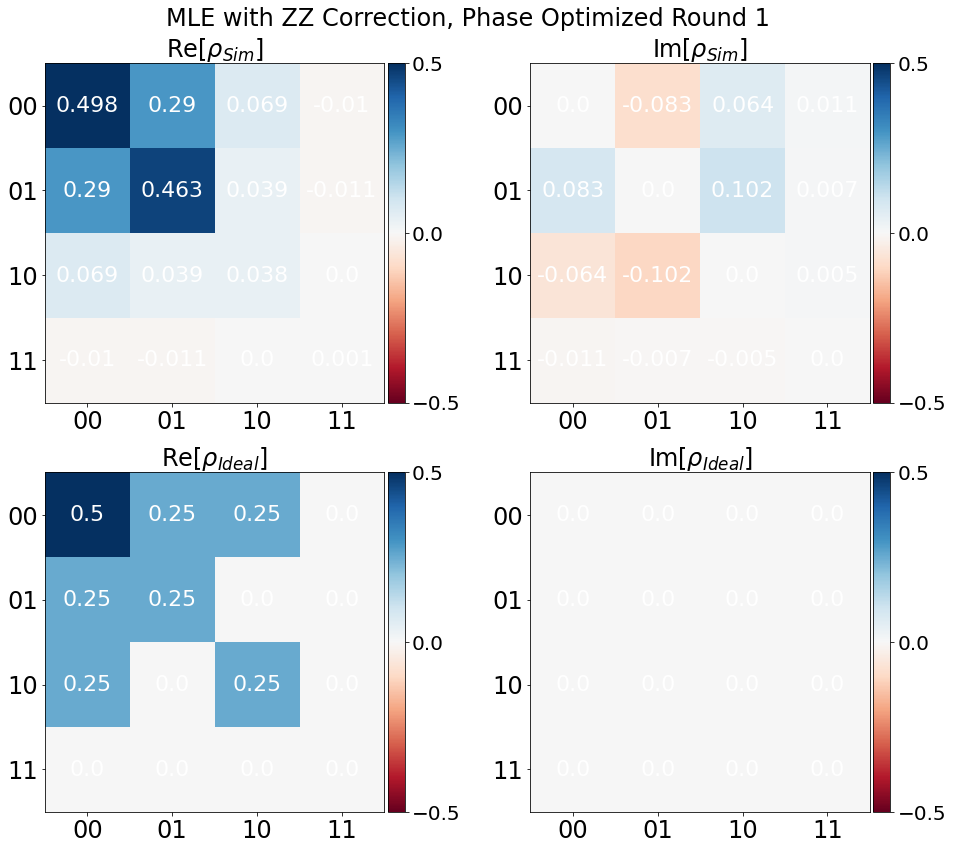

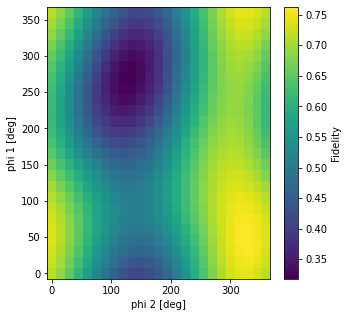

100%|██████████| 25/25 [00:02<00:00, 11.72it/s]


Improved fidelity by (%) 4.708141887910699
[[ 0.498+0.j     0.295-0.065j  0.075+0.057j -0.009+0.011j]
 [ 0.295+0.065j  0.463+0.j     0.055+0.094j -0.01 +0.008j]
 [ 0.075-0.057j  0.055-0.094j  0.038+0.j    -0.   +0.005j]
 [-0.009-0.011j -0.01 -0.008j -0.   -0.005j  0.001+0.j   ]]
Fidelity (after rotation round 2): 0.7629717437638921
Best rotation round 2: [0.890117918517108, 5.696754678509491]


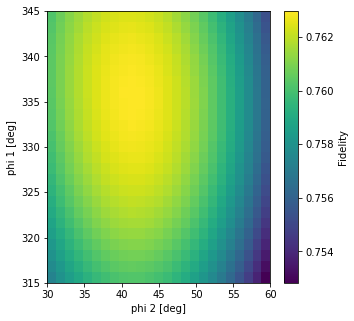

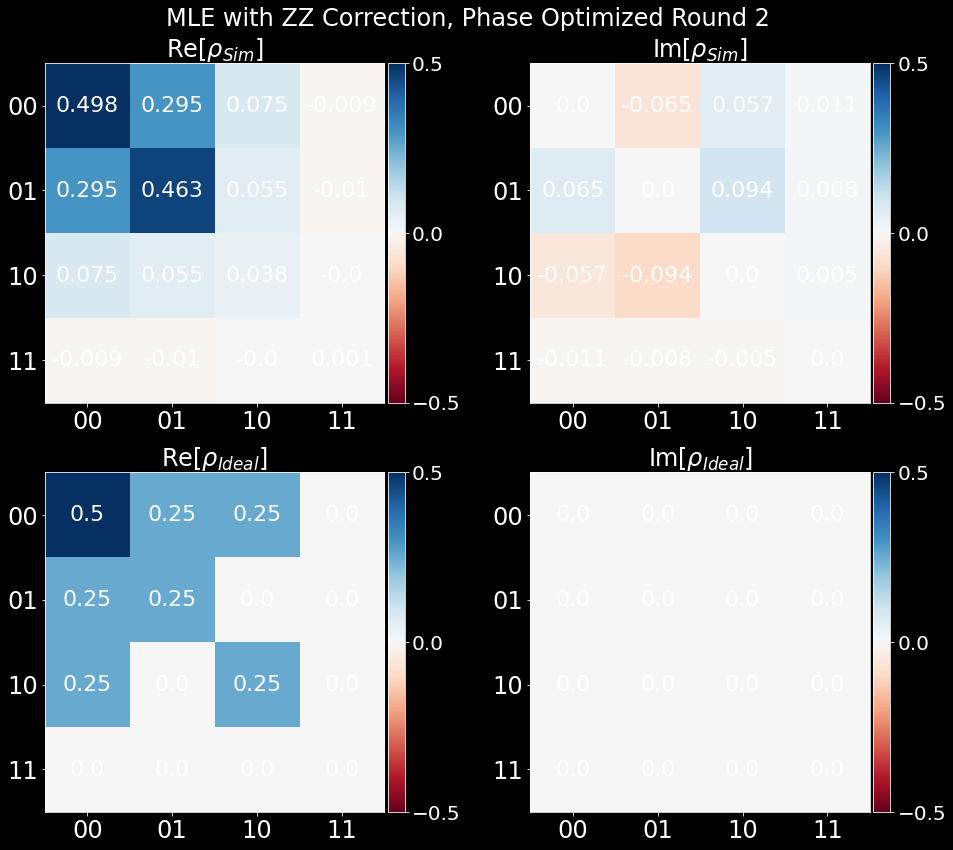

 <ipython-input-3-2e4d5b4b62eb>: 73MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
 <ipython-input-3-2e4d5b4b62eb>: 84UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
 <ipython-input-3-2e4d5b4b62eb>: 91

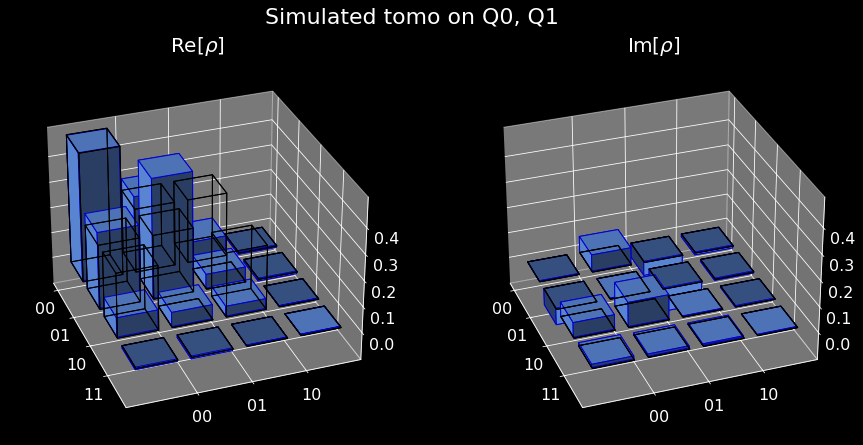

In [56]:
nphi_round1 = 25
nphi_round2 = 25

rho_rot, best_phis, best_fid, all_fids = opt_virtualZ_MLE(qt.Qobj(rho_result2q, dims=rho_id.dims), rho_id, nphi=nphi_round1)

fid_ZZ_rot = best_fid
print(f'Fidelity (after rotation round 1): {fid_ZZ_rot}')
print(f'Best rotation round 1: {best_phis}')
show_plot_rho_2d(rho_rot, rho_id, title='MLE with ZZ Correction, Phase Optimized Round 1') #, cmax=1.0)

phis = np.linspace(0, 2*np.pi, nphi_round1)
plt.figure(figsize=(5,5))
plt.pcolormesh(phis*180/np.pi, phis*180/np.pi, all_fids, cmap='viridis', shading='auto')
plt.xlabel("phi 2 [deg]")
plt.ylabel("phi 1 [deg]")
plt.colorbar(label='Fidelity')
plt.show()

phi_mins = np.array(best_phis)-2*np.pi/nphi_round1
phi_maxs = np.array(best_phis)+2*np.pi/nphi_round1
rho_rot, best_phis, best_fid, all_fids = opt_virtualZ_MLE(qt.Qobj(rho_result2q, dims=rho_id.dims), rho_id, nphi=nphi_round2, phi_mins=phi_mins, phi_maxs=phi_maxs)
fid_ZZ_rot = best_fid
print(np.around(rho_rot, decimals=3))
print(f'Fidelity (after rotation round 2): {fid_ZZ_rot}')
print(f'Best rotation round 2: {best_phis}')

phis1 = np.linspace(phi_mins[0], phi_maxs[0], nphi_round2)
phis2 = np.linspace(phi_mins[1], phi_maxs[1], nphi_round2)
plt.figure(figsize=(5,5))
plt.pcolormesh(phis1*180/np.pi, phis2*180/np.pi, all_fids, cmap='viridis', shading='auto')
plt.xlabel("phi 2 [deg]")
plt.ylabel("phi 1 [deg]")
plt.colorbar(label='Fidelity')
plt.show()

show_plot_rho_2d(rho_rot, rho_id, title='MLE with ZZ Correction, Phase Optimized Round 2', cmax=None, savetitle='0+1_0+1_simulated_flat.png')
show_plot_rho_3d(rho_sim=rho_rot.full(), rho_id=rho_id.full(), title=f'Simulated tomo on Q{tomo_qubits[0]}, Q{tomo_qubits[1]}', width=0.75, elev=30, azim=-20) #, savetitle='0+1_0+1_simulated.png')

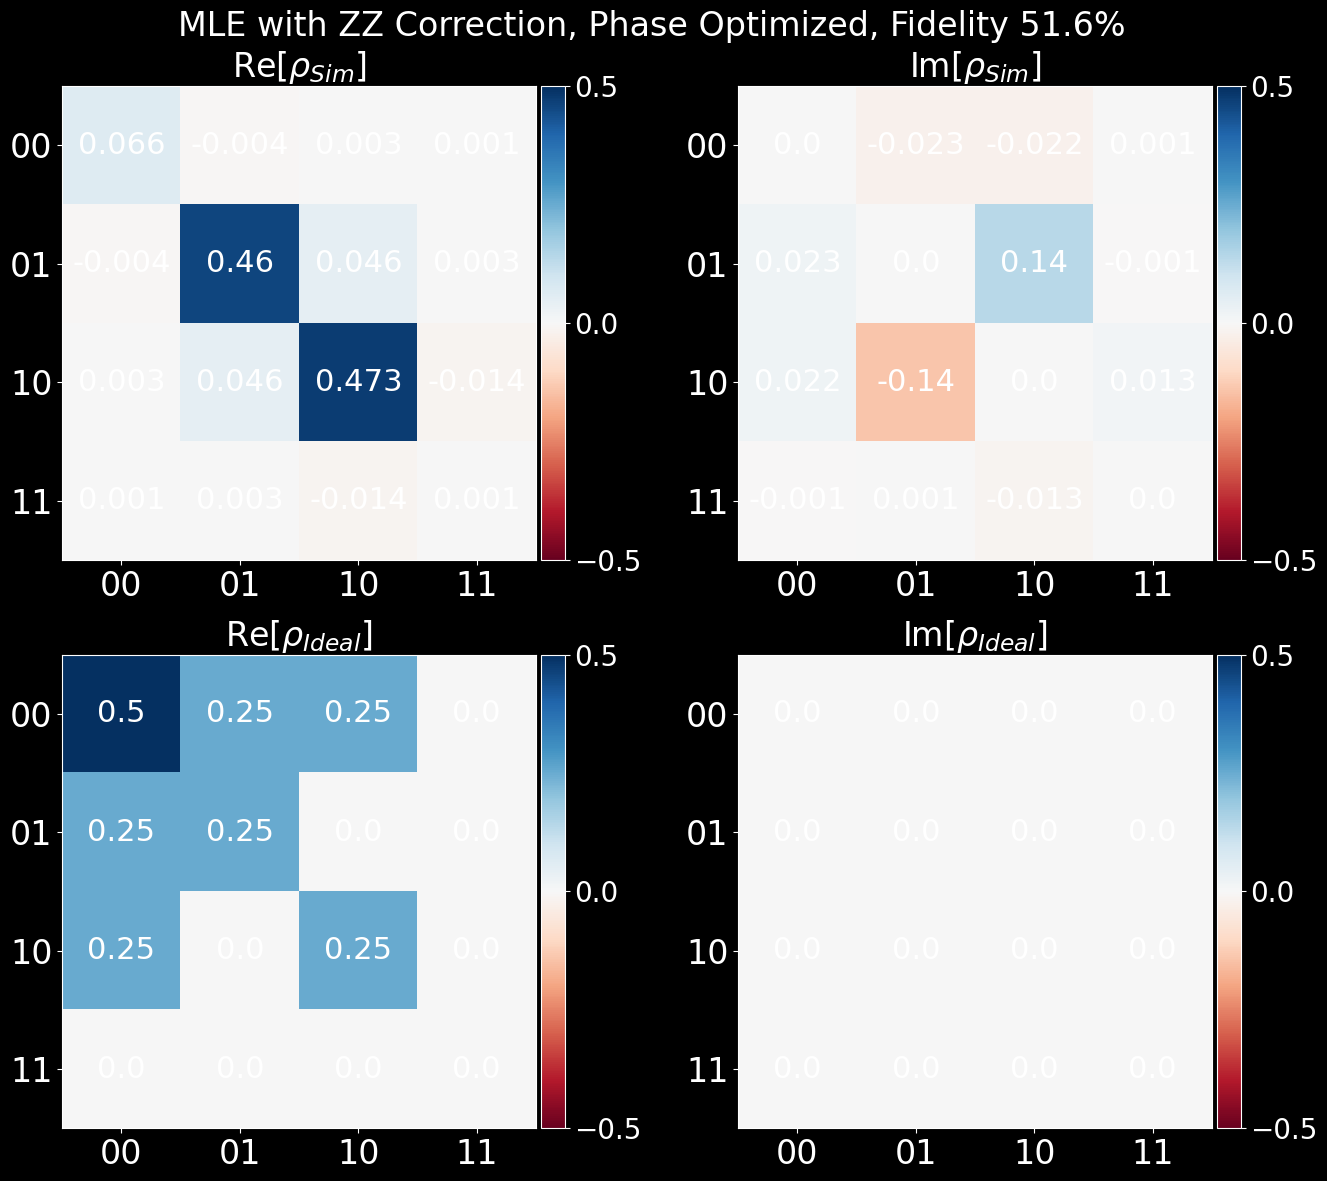

 <ipython-input-11-2e4d5b4b62eb>: 91

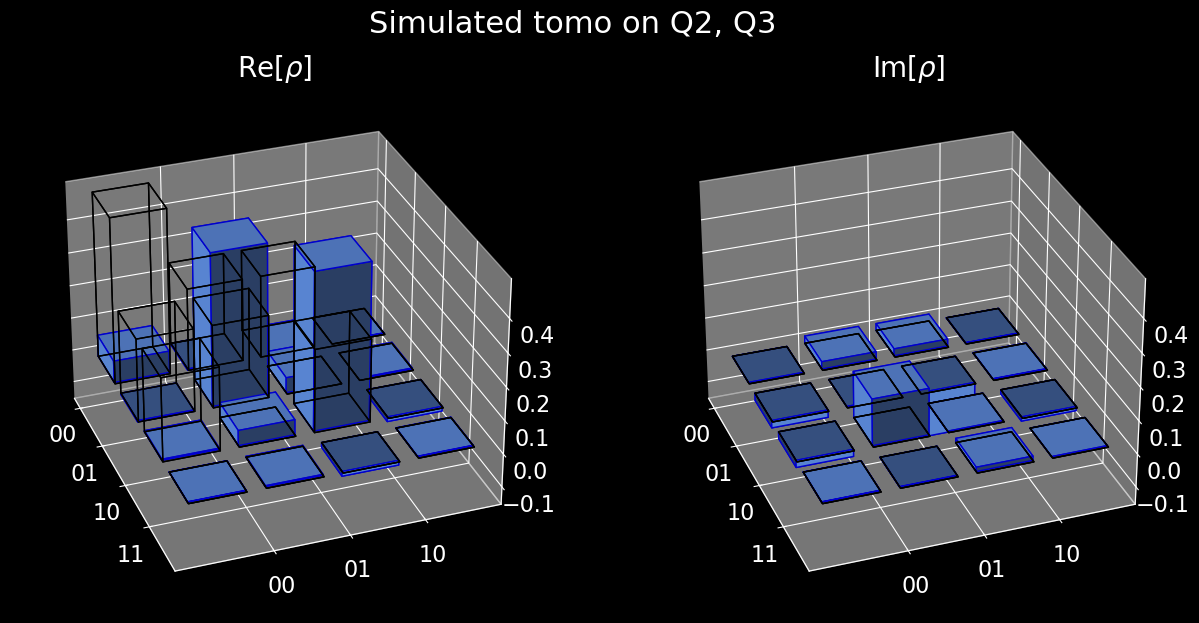

In [ ]:
z_phi12 = z_gate_2q(2.4609142453120043, 3.7699111843077517)
rho_rot = (z_phi12*rho_result2q*z_phi12.dag()).unit() 
fid = qt.fidelity(rho_rot, rho_id)**2
show_plot_rho_2d(rho_rot, rho_id, title=f'MLE with ZZ Correction, Phase Optimized, Fidelity {100*fid:.3}%', cmax=None, savetitle='0+i1_0+1_simulated_flat.png')
show_plot_rho_3d(rho_sim=rho_rot.full(), rho_id=rho_id.full(), title=f'Simulated tomo on Q{tomo_qubits[0]}, Q{tomo_qubits[1]}', width=0.75, elev=30, azim=-20) #, savetitle='0+1_0+1_simulated.png')

In [12]:
print('want', qram.get_base_wd('eggg', 'gfgg')/2/np.pi)
print('want', qram.get_base_wd('eegg', 'eggg')/2/np.pi)
# print('want', qram.get_wd('eggg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('eegg', 'gfgg', 0.10, verbose=False)/2/np.pi)
# print('want', qram.get_wd('ggge', 'gege', 0.05, verbose=False)/2/np.pi)
# print('resonant to', qram.get_wd('ggeg', 'geeg', 0.05)/2/np.pi)
# print('2 photon transition to', qram.get_base_wd('eggg', 'efgg')/2/np.pi)

want 2.1692639480132065
want 3.6869102975757024
